This notebook contains a basic Convolutional Neural Network (CNN) example for image classification. The code was written in Python PyTorch.

Implement a Convolutional Neural Network (CNN) to perform image classification on a subset of the CIFAR-10 dataset, focusing on three categories: cat, dog, and horse.

**Dataset**: A subset of the CIFAR-10 dataset. This subset includes $15,000$ training images ($15000 \times 32 \times 32 \times 3$) and $3,000$ test images ($3000 \times 32 \times 32 \times 3$). Only three categories are featured: cat, dog, and horse. The dataset is in a file named "cifa10_3classes.h5".

In [1]:
import h5py
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

%matplotlib inline
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# function to load data from HDF5 file
def load_hdf5(filename):
    with h5py.File(filename, 'r') as f:
        train_images = f['train_images'][:]
        train_labels = f['train_labels'][:]
        test_images = f['test_images'][:]
        test_labels = f['test_labels'][:]
    return train_images, train_labels, test_images, test_labels

In [3]:
train_images, train_labels, test_images, test_labels = load_hdf5("data/cifa10_3classes.h5")
train_labels = train_labels.reshape(-1)
test_labels = test_labels.reshape(-1)

shapes = pd.DataFrame({
    'Shape': [data.shape for data in (train_images, train_labels, test_images, test_labels)]
})
shapes.index = ["Training Iamges", "Training Labels", "Test Images", "Test Labels"]
display(shapes)

,Shape
Training Iamges,"(15000, 32, 32, 3)"
Training Labels,"(15000,)"
Test Images,"(3000, 32, 32, 3)"
Test Labels,"(3000,)"


<p style="page-break-after:always;"></p>

Construct my own convolutional neural network using PyTorch.

In [4]:
class ImageDataset(Dataset):
    def __init__(self, images, targets, transform=None):
        self.images = images
        self.targets = targets
        self.transform = transform
    
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image, target

In [5]:
class Net(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.25):
        super(Net, self).__init__()
        hidden_sizes = [12, 24, 64]
        self.conv1 = nn.Conv2d(
            in_channels=in_channels, out_channels=hidden_sizes[0], 
            kernel_size=5, stride=1
        )
        self.bn1 = nn.BatchNorm2d(hidden_sizes[0])
        self.conv2 = nn.Conv2d(
            in_channels=hidden_sizes[0], out_channels=hidden_sizes[0], 
            kernel_size=5, stride=1
        )
        self.bn2 = nn.BatchNorm2d(hidden_sizes[0])
        self.conv3 = nn.Conv2d(
            in_channels=hidden_sizes[0], out_channels=hidden_sizes[1], 
            kernel_size=5, stride=1
        )
        self.bn3 = nn.BatchNorm2d(hidden_sizes[1])
        self.conv4 = nn.Conv2d(
            in_channels=hidden_sizes[1], out_channels=hidden_sizes[1], 
            kernel_size=5, stride=1
        )
        self.bn4 = nn.BatchNorm2d(hidden_sizes[1])
        self.fc5 = nn.Linear(hidden_sizes[1]*4*4, hidden_sizes[2])
        self.fc6 = nn.Linear(hidden_sizes[2], out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        output = self.relu(self.bn1(self.conv1(x)))         # (n, 12, 28, 28)
        output = self.relu(self.bn2(self.conv2(output)))    # (n, 12, 24, 24)
        output = self.pool(output)                          # (n, 12, 12, 12)
        output = self.relu(self.bn3(self.conv3(output)))    # (n, 24, 8, 8)
        output = self.relu(self.bn4(self.conv4(output)))    # (n, 24, 4, 4)
        output = output.view(x.size(dim=0), -1)             # (n, 24*4*4)
        output = self.dropout(output)
        output = self.relu(self.fc5(output))                # (n, 64)
        output = self.dropout(output)
        output = self.fc6(output)                           # (n, 3)
        return output

In [12]:
batch_size = 256
lr = 1e-3
dropout = 0.75
decay = 0.0
epochs = 400

torch.manual_seed(1)
np.random.seed(1)

In [13]:
# datasets
train_transform = A.Compose([
    A.RandomRotate90(),
    A.Flip(),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
    A.Normalize(mean=(0.499, 0.467, 0.416), std=(0.250, 0.247, 0.253)),
    ToTensorV2()
])
test_transform = A.Compose([
    A.Normalize(mean=(0.499, 0.467, 0.416), std=(0.250, 0.247, 0.253)),
    ToTensorV2()
])
train_dataset = ImageDataset(train_images, train_labels, transform=train_transform)
test_dataset = ImageDataset(test_images, test_labels, transform=test_transform)
train_dataloader = DataLoader(
    dataset=train_dataset,
    shuffle=True,
    drop_last=True,
    batch_size=batch_size
)
test_dataloader = DataLoader(
    dataset=test_dataset,
    shuffle=False,
    drop_last=False,
    batch_size=batch_size
)
dataloaders = {'Train': train_dataloader, 'Test': test_dataloader}
# model
model = Net(in_channels=3, out_channels=3, dropout=dropout)
model = model.to(device)
# training configuration
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=decay)
#optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)

The architecture is illustrated by the following diagram.

<img src="images/architecture.png">

I used two sets of double convolutional layers, and two fully connected layers. In the double convolutional layers, I used 2D convolutional layers with $5 \times 5$ kernel, rectified linear units (ReLU) as activation functions, and max pooling layers with kernel $2 \times 2$. I used 12 features for the first set of double convolutional layers, and 24 features for the second set of double convolutional layers. The features from the convolutional layers are flattened before entering the fully connected layers. I used 64 nodes in the first fully connected layer, and 3 nodes in the output layer, corresponding to the 3 classes, namely cat, dog, and horse. I also used ReLU as an activation function after the 64-node fully connected layer. To prevent over-fitting, I applied dropout with probability $0.75$ to the flattened layer and the 64-node fully connected layer.

I used the cross entropy loss function and the Adam optimizer.

To prevent over-fitting, I used random shuffle, drop last, random rotation, random flip, and random brightness contrast in the training dataloader. The idea is to increase the training set by creating modified copies of existing data. I disabled those operations in the test dataloader.

I used a batch size of $256$, a learning rate of $1 \times 10^{-3}$. I will train the model for $400$ epochs.

<p style="page-break-after:always;"></p>

Train model on the CIFAR-10 subset.

In [2]:
# train/validation accuracy for each epoch
accuracy_dict = {
    'Train_Loss': [],
    'Train_Accuracy': [],
    'Test_Loss': [],
    'Test_Accuracy': []
}
# each epoch consists of train and validation
phases = ['Train', 'Test']

# training loop
for j in range(epochs):
    for phase in phases:
        if phase == 'Train':
            model.train()
        else:
            model.eval()
        running_loss = 0.0
        running_correct = 0
        running_total = 0
        for train_i, train_t in dataloaders[phase]:
            # prediction
            train_i = train_i.to(device).float()
            train_t = train_t.to(device).long()
            pred_t = model(train_i)
            # calculating loss
            loss = criterion(pred_t, train_t)
            # backprop
            if phase == 'Train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            # update loss and accuracy
            # convert logits to predicted labels
            preds = torch.argmax(pred_t, dim=1)
            running_loss += loss.item()
            running_correct += (preds == train_t).sum().item()
            running_total += train_t.size(0)
        epoch_loss = running_loss / len(dataloaders[phase])
        epoch_accuracy = running_correct / running_total
        accuracy_dict[f"{phase}_Loss"].append(epoch_loss)
        accuracy_dict[f"{phase}_Accuracy"].append(epoch_accuracy)
    if (j+1)%50 == 0:
        print("-"*10)
        print(f"Epoch {j+1}/{epochs}")
        print(f"Training Loss: {accuracy_dict['Train_Loss'][-1]:.5f}")
        print(f"Training Accuracy: {accuracy_dict['Train_Accuracy'][-1]:.2%}")
        print(f"Test Loss: {accuracy_dict['Test_Loss'][-1]:.5f}")
        print(f"Test_Accuracy: {accuracy_dict['Test_Accuracy'][-1]:.2%}")

----------
Epoch 100/400
Training Loss: 0.76625
Training Accuracy: 64.96%
Test Loss: 0.78232
Test_Accuracy: 64.80%
----------
Epoch 200/400
Training Loss: 0.68862
Training Accuracy: 71.01%
Test Loss: 0.64893
Test_Accuracy: 71.77%
----------
Epoch 300/400
Training Loss: 0.63931
Training Accuracy: 73.35%
Test Loss: 0.62781
Test_Accuracy: 72.97%
----------
Epoch 400/400
Training Loss: 0.60078
Training Accuracy: 74.60%
Test Loss: 0.58819
Test_Accuracy: 75.97%


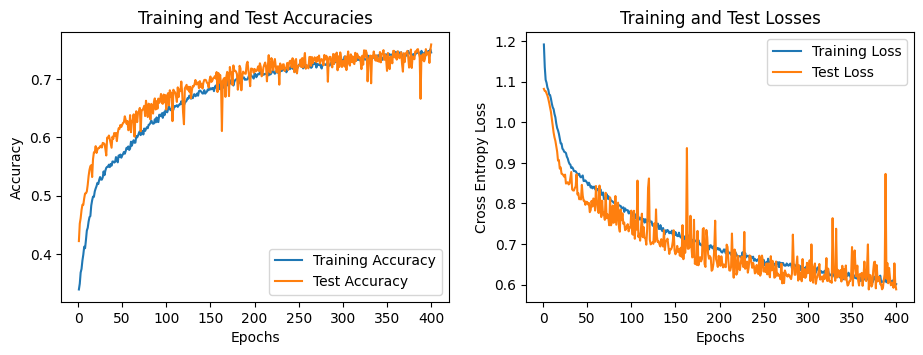

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (11,3.5))
# plot accuracies
ax[0].plot(
    range(1, epochs+1), accuracy_dict["Train_Accuracy"], 
    label="Training Accuracy"
)
ax[0].plot(
    range(1, epochs+1), accuracy_dict["Test_Accuracy"],
    label="Test Accuracy"
)
ax[0].set_title("Training and Test Accuracies")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].legend(loc="lower right")
# plot losses
ax[1].plot(
    range(1, epochs+1), accuracy_dict["Train_Loss"], 
    label="Training Loss"
)
ax[1].plot(
    range(1, epochs+1), accuracy_dict["Test_Loss"],
    label="Test Loss"
)
ax[1].set_title("Training and Test Losses")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Cross Entropy Loss")
ax[1].legend(loc="upper right")

plt.show()

<p style="page-break-after:always;"></p>

Evaluate the model using the test data.

In [16]:
pred_labels = []

model.eval()
for test_i, test_l in dataloaders['Test']:
    # prediction
    test_i = test_i.to(device).float()
    pred_l = model(test_i)
    # convert logits to predicted labels
    preds = torch.argmax(pred_l, dim=1).cpu().flatten().tolist()
    pred_labels.extend(preds)

pred_labels = np.array(pred_labels)

In [17]:
# confusion matrix
confusion_test = pd.crosstab(test_labels, pred_labels)
confusion_test.index = ["Actual: Cat", "Actual: Dog", "Actual: Horse"]
confusion_test.columns = ["Predicted: Cat", "Predicted: Dog", "Predicted: Horse"]

display(confusion_test)

,Predicted: Cat,Predicted: Dog,Predicted: Horse
Actual: Cat,723,198,79
Actual: Dog,204,717,79
Actual: Horse,90,71,839
